<a href="https://colab.research.google.com/github/Cralsic123/DeeplabV3net-comparison/blob/main/DeeplabV3net_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 33% 5.00M/15.1M [00:00<00:00, 35.5MB/s]
100% 15.1M/15.1M [00:00<00:00, 83.4MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('/content/brain-mri-images-for-brain-tumor-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./')


In [4]:
import tensorflow as tf
import numpy as np
import cv2



In [ ]:
interpreter = tf.lite.Interpreter(model_path="deeplabv3_plus_mobilenet.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [ ]:
input_details

[{'name': 'image',
  'index': 0,
  'shape': array([  1, 513, 513,   3], dtype=int32),
  'shape_signature': array([  1, 513, 513,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
def preprocess_image(image_path, target_size):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)

    return image


In [ ]:
input_shape = input_details[0]['shape']
target_size = (input_shape[1], input_shape[2])


## Running Conclusions

In [ ]:
def run_inference(image):
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

In [ ]:
def postprocess_output(output_data, original_image_shape):
    # Removing dimension and resizing to original image shape
    output_image = np.squeeze(output_data)
    output_image = cv2.resize(output_image, (original_image_shape[1], original_image_shape[0]))

    # Apply threshold to get binary mask
    output_mask = output_image > 0.5

    return output_mask

In [ ]:
mri_image_path = "/content/yes/Y1.jpg"
original_image = cv2.imread(mri_image_path)


In [ ]:
preprocessed_image = preprocess_image(mri_image_path, target_size)
output_data = run_inference(preprocessed_image)
segmentation_mask = postprocess_output(output_data, original_image.shape)


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
cv2_imshow(segmentation_mask.astype(np.uint8) * 255)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 21


## NEW APPROACH


In [31]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="deeplabv3_plus_mobilenet.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((input_details[0]['shape'][1], input_details[0]['shape'][2]))
    img = np.array(img, dtype=np.float32)
    img = np.expand_dims(img, axis=0)
    img = img / 127.5 - 1  # Normalize to [-1, 1]
    return img

# Function to run the model on an image
def run_tflite_model(image_path):
    input_data = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data


In [30]:
import os

mri_image_dir = '/content/brain_tumor_dataset/yes/'
mri_images = [os.path.join(mri_image_dir, img) for img in os.listdir(mri_image_dir) if img.endswith('.png') or img.endswith('.jpg')]

results = []
for img_path in mri_images:
    prediction = run_tflite_model(img_path)
    results.append(prediction)


ValueError: Cannot set tensor: Dimension mismatch. Got 3 but expected 4 for input 0.

In [29]:
prediction

NameError: name 'prediction' is not defined

In [7]:
import torch
import torchvision.models as models

# Load a pretrained MobileNetV2 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

# Convert predictions from TFLite to torch tensors if needed
torch_predictions = [torch.tensor(pred) for pred in results]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:12<00:00, 19.6MB/s]


In [9]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [11]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt

# Initialize Grad-CAM with the model's target layer
cam_extractor = GradCAM(model, target_layer='backbone.layer4')

# Assuming you have the MRI image as a numpy array
def visualize_gradcam(image_path, torch_model, cam_extractor):
    img = preprocess_image(image_path).squeeze(0)
    img_tensor = torch.tensor(img).permute(2, 0, 1)  # Convert to CxHxW
    output = torch_model(img_tensor.unsqueeze(0))

    # Use the output of your classifier (e.g., class index 0 for binary classification)
    activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)

    # Convert activation map and overlay
    result = overlay_mask(img, activation_map[0], alpha=0.5)

    plt.imshow(result)
    plt.show()

# Visualize Grad-CAM for each MRI image
for img_path in mri_images:
    visualize_gradcam(img_path, model, cam_extractor)


Another approach


In [19]:
!pip install pytorch-gradcam


In [21]:
!pip install pytorch-gradcam

In [22]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional

ModuleNotFoundError: No module named 'pytorch_grad_cam'

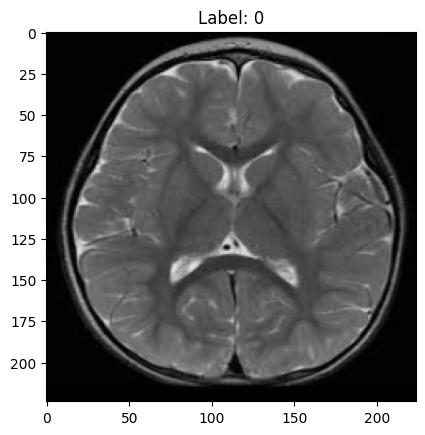

In [12]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Define the path to your dataset
data_dir = '/content/brain_tumor_dataset'

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a fixed size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

# Custom Dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["no", "yes"]
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load the dataset
dataset = BrainTumorDataset(root_dir=data_dir, transform=transform)

# Create a DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example: Display an image from the dataset
def show_image(img_tensor, label):
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f'Label: {label}')
    plt.show()

# Display a sample image and label
sample_img, sample_label = dataset[0]
show_image(sample_img, sample_label)


In [32]:
import torch

In [ ]:
torch_model =

In [ ]:
!pip install qai-hub-models


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 103.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.5/324.5 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━